In [2]:
import os
import sys
import pathlib
import subprocess
import numpy as np

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from lab import tracev2
from scipy import stats
from sklearn.feature_selection import mutual_info_regression

sys.path.append(os.path.abspath('../scripts'))
import common
from common import timeseries

In [14]:
scores = pd.read_csv("../../results/shaping-eval/shaping-eval/front/scores.csv")
scores.sort_values(by="pearsonr").head()

,sample,rate,dir,pearsonr,scaled_euclidean,scaled_dtw
562,results/shaping-eval/front/dataset/0109/1_0,50ms,in,-0.055535,2.326858,1.957909
560,results/shaping-eval/front/dataset/0109/1_0,25ms,in,-0.041123,2.378725,1.636385
213,results/shaping-eval/front/dataset/0038/2_0,25ms,out,-0.028913,1.129592,1.708940
215,results/shaping-eval/front/dataset/0038/2_0,50ms,out,-0.028139,1.291982,1.692965
10,results/shaping-eval/front/dataset/0001/1_0,50ms,in,-0.023917,1.047959,1.713981


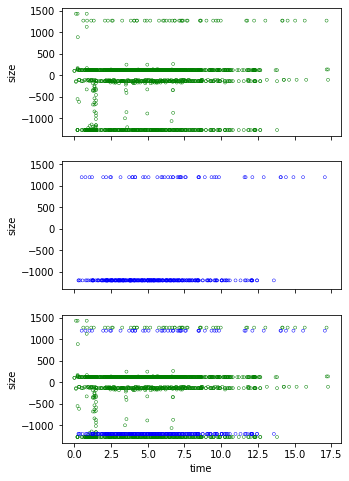

In [15]:
path = pathlib.Path("../../results/shaping-eval/shaping-eval/front/dataset/0038/2_0/defended/")

def main():
    """Run neqo collection."""
    trace_data = tracev2.from_csv(path / "trace.csv")

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(5, 8))
    for i in (0, 2):
        sns.scatterplot(data=pd.DataFrame(trace_data), x="time", y="size",
                        ax=axes[i], marker='.', edgecolor="green",
                        facecolor="none")
        
    trace_data = tracev2.from_csv(path / "schedule.csv")
    for i in (1, 2):
        sns.scatterplot(data=pd.DataFrame(trace_data), x="time", y="size",
                        ax=axes[i], marker='.', edgecolor="blue",
                        facecolor="none")

main()

In [3]:
path = pathlib.Path("../../results/debug/buflo-reg-client/dataset/0010/0_0/")
frame = timeseries.from_csv(path / "trace.csv").join(timeseries.from_csv(path / "schedule.csv"), how="outer", lsuffix="-trace", rsuffix="-sched").fillna(0)#.resample("5ms").sum()
frame

# frame[frame < 150] = 0
# frame = frame.resample("100ms").sum()
frame

is_outgoing,in-trace,out-trace,in-sched,out-sched
time,,,,
0 days 00:00:00,0.0,104.0,0.0,0.0
0 days 00:00:00.000041,0.0,104.0,0.0,0.0
0 days 00:00:00.005000,0.0,0.0,750.0,750.0
0 days 00:00:00.010000,0.0,0.0,750.0,750.0
0 days 00:00:00.015000,0.0,0.0,750.0,750.0
...,...,...,...,...
0 days 00:00:05.026346,0.0,136.0,0.0,0.0
0 days 00:00:05.027982,856.0,0.0,0.0,0.0
0 days 00:00:05.028178,0.0,616.0,0.0,0.0


<AxesSubplot:ylabel='Density'>

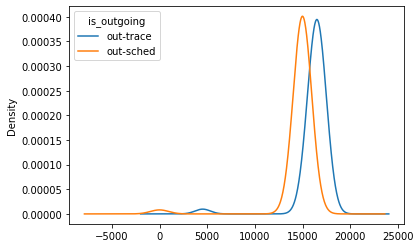

In [89]:
fig, ax = plt.subplots()
frame[["out-trace", "out-sched"]].plot.kde(ax=ax)

In [90]:
discrete = True
dir_ = "out"

mi = mutual_info_regression(frame[f"{dir_}-sched"].to_numpy().reshape((-1, 1)), frame[f"{dir_}-trace"], discrete_features=discrete)[0]
entropy1 =  mutual_info_regression(frame[f"{dir_}-sched"].to_numpy().reshape((-1, 1)), frame[f"{dir_}-sched"], discrete_features=discrete)[0]
entropy2 =  mutual_info_regression(frame[f"{dir_}-trace"].to_numpy().reshape((-1, 1)), frame[f"{dir_}-trace"], discrete_features=discrete)[0]
print(mi, entropy1, entropy2)

mi / (0.5 * (entropy1 + entropy2))

0 0.1815665513631608 1.1408295981778493


0.0

NameError: name 'x' is not defined

In [114]:
import itertools

def mutual_info(x, y):
    kde1 = stats.gaussian_kde(x)
    kde2 = stats.gaussian_kde(y)
    joint = stats.gaussian_kde(np.array([x, y]))
    
    x_vals = np.linspace(np.min(x), np.max(x), num=100, endpoint=True)
    y_vals = np.linspace(np.min(y), np.max(y), num=100, endpoint=True)
    
    triplets = [(joint.pdf(tup)[0], kde1.pdf(tup[0])[0], kde2.pdf(tup[1])[0]) for tup in itertools.product(*[x_vals, y_vals])]
    return np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])
    
mutual_info(frame["out-sched"], frame["out-trace"])

<ipython-input-114-f4f5c57b78f6>:12: RuntimeWarning: divide by zero encountered in log
  return np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])
<ipython-input-114-f4f5c57b78f6>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum([p_xy * (np.log(p_xy) - np.log(p_x) - np.log(p_y)) for p_xy, p_x, p_y in triplets])


nan

In [496]:
import pytwed

x = frame["out-trace"][frame["out-trace"] > 0]
x_measures = x.to_numpy()
x_ts = x.index.to_series().dt.total_seconds().to_numpy()

y = frame["out-sched"][frame["out-sched"] > 0]
y_measures = y.to_numpy()
y_ts = y.index.to_series().dt.total_seconds().to_numpy()

In [5]:
frame2 = frame.copy()
# display(frame2[frame2 > 0].min())
# frame2[["in-trace", "out-trace"]] -= 104
# frame2[frame2 < 0] = 0
# display(frame2[frame2 > 0].min())
# frame2[frame2 < 150] = 0
# frame2 /= 1500
# frame2[(frame2 > 0) & (frame2 <= 500)] = 1
# frame2[(frame2 > 500) & (frame2 <= 1000)] = 2
# frame2[(frame2 > 1000)] = 3
# frame2 = frame2.astype(int)
# frame2.resample("4ms").sum()
frame2

is_outgoing,in-trace,out-trace,in-sched,out-sched
time,,,,
0 days 00:00:00,0.0,104.0,0.0,0.0
0 days 00:00:00.000041,0.0,104.0,0.0,0.0
0 days 00:00:00.005000,0.0,0.0,750.0,750.0
0 days 00:00:00.010000,0.0,0.0,750.0,750.0
0 days 00:00:00.015000,0.0,0.0,750.0,750.0
...,...,...,...,...
0 days 00:00:05.026346,0.0,136.0,0.0,0.0
0 days 00:00:05.027982,856.0,0.0,0.0,0.0
0 days 00:00:05.028178,0.0,616.0,0.0,0.0


In [14]:
import tslearn.metrics
frame2 = frame2.resample("1ms").sum()
x = frame2["out-trace"]
y = frame2["out-sched"]

# display(tslearn.metrics.lcss(frame2["out-trace"], frame2["out-sched"], eps=100, sakoe_chiba_radius=100, global_constraint="sakoe_chiba"))
# display(tslearn.metrics.lcss(frame2["in-trace"], frame2["in-sched"], eps=100, sakoe_chiba_radius=100, global_constraint="sakoe_chiba"))
# display(tslearn.metrics.lcss(frame2["out-trace"], [0] * len(frame2["out-trace"]), eps=100, sakoe_chiba_radius=100, global_constraint="sakoe_chiba"))
# display(tslearn.metrics.lcss(x[x > 150], y[y > 150], eps=150))
# display(tslearn.metrics.lcss([0] * len(x[x > 150]), y[y > 150], eps=150))

In [16]:
import fastdtw
x = x[x > 150]
y = y[y > 150]

worst = [1500 - val for val in y]
worst += [1500] * (len(x) - len(y))

# M = fastdtw.fastdtw(np.array([0] * len(x)), y)[0]
M = sum(worst)

# display([1500 - val for val in y])
# M = max(len(x[x > 150]), len(y[y > 150])) * 1500

display((M - fastdtw.fastdtw([0] * len(x), y)[0])/M)
display((M - fastdtw.fastdtw(x, y)[0])/M)

0.0

0.6858698698698699